In [1]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# !nvidia-smi # model 이 GPU에 잘 올라갔는지 확인 가능

Mounted at /content/drive
cpu


In [2]:
# for random seed
import numpy as np
import random 
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
BATCH_SIZE = 5
LR = 1e-3
LR_STEP = 20
LR_GAMMA = 0.9
EPOCH = 1000
criterion = nn.MSELoss()
NoL = 2
NoC = 1000
nx, ny, mx, my = 40, 40, 150, 50 # x, y축 폭 & x, y축 최솟값
regularization = "l2"
if regularization == "l2":
    LAMBDA = 100
elif regularization == "l1":
    LAMBDA = 5e-3
new_model_train = False
model_type = f"L{NoL}C{NoC}_{regularization}"
save_best_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/Regularization/best_{model_type}.pt"
save_final_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/Regularization/final_{model_type}.pt"
save_video_path = f"results/L2C1000.mp4"

In [4]:
def data_tr(x,n,m):
    return (x-m)/n

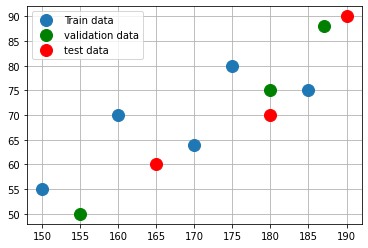

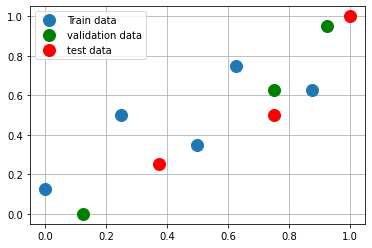

In [5]:
x = torch.tensor([150., 160, 170, 175, 185]).reshape(-1,1) # 키
y = torch.tensor([55., 70, 64, 80, 75]).reshape(-1,1) # 몸무게

xv = torch.tensor([155., 180, 187]).reshape(-1,1)
yv = torch.tensor([50., 75, 88]).reshape(-1,1)

xt = torch.tensor([165., 180, 190]).reshape(-1,1)
yt = torch.tensor([60., 70, 90]).reshape(-1,1)

plt.plot(x,y,'o', markersize=12, label="Train data")
plt.plot(xv,yv,'go', markersize=12, label="validation data")
plt.plot(xt,yt,'ro', markersize=12, label="test data")
plt.grid()
plt.legend(loc="best")

X = data_tr(x,nx,mx)
Y = data_tr(y,ny,my)
Xv = data_tr(xv,nx,mx)
Yv = data_tr(yv,ny,my)
Xt = data_tr(xt,nx,mx)
Yt = data_tr(yt,ny,my)
plt.figure()
plt.plot(X,Y,'o', markersize=12, label="Train data")
plt.plot(Xv,Yv,'go', markersize=12, label="validation data")
plt.plot(Xt,Yt,'ro', markersize=12, label="test data")
plt.grid()
plt.legend(loc="best")

In [6]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x)
        y = self.Y[idx]
        return x, y

In [7]:
train_DS = Custom_Dataset(X, Y)
val_DS = Custom_Dataset(Xv, Yv)
test_DS = Custom_Dataset(Xt, Yt)

train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = False)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size = BATCH_SIZE, shuffle = False)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = False)

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        if NoL == 1 :
            self.fcs = nn.Sequential()
        else:
            self.fcs = nn.Sequential(
                nn.Linear(1,NoC),
                nn.ReLU(),
                *[i for j in range(NoL-2) for i in [nn.Linear(NoC,NoC), nn.ReLU()]],
            )
        self.fc_out = nn.Linear(NoC,1)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fc_out(x)
        return x

In [9]:
model=MLP().to(DEVICE)
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape)

MLP(
  (fcs): Sequential(
    (0): Linear(in_features=1, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc_out): Linear(in_features=1000, out_features=1, bias=True)
)
torch.Size([5, 1])


In [10]:
def Train(model, train_DL, val_DL, criterion, **kwargs):
    params = [p for p in model.parameters() if p.requires_grad] # for transfer learning
    optimizer=optim.Adam(params, lr = kwargs["LR"])
    lr_scheduler = StepLR(optimizer, step_size = kwargs["LR_STEP"], gamma=kwargs["LR_GAMMA"])

    loss_history = {"train": [], "val": []}
    mean_weight_history=[]
    x_plot = torch.linspace(145,200,100).reshape(-1,1)
    y_plot_history = []

    best_loss = torch.inf
    for ep in range(kwargs["EPOCH"]):
        epoch_start = time.time()
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch: {ep}, current_LR = {current_lr}")

        model.train()
        train_loss, rweight = loss_epoch(model, train_DL, criterion, optimizer = optimizer)
        loss_history["train"] += [train_loss]
        mean_weight_history += [rweight/len(train_DL)]

        model.eval()
        with torch.no_grad():
            val_loss, _ = loss_epoch(model, val_DL, criterion)
            y_plot_history += [model(data_tr(x_plot, nx, mx))*ny+my]
            loss_history["val"] += [val_loss]
                    # save model test output
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "EPOCH": kwargs["EPOCH"],
                            "ep": ep,
                            "LR": kwargs["LR"],
                            "LR_STEP": kwargs["LR_STEP"],
                            "LR_GAMMA": kwargs["LR_GAMMA"],
                            "BATCH_SIZE": kwargs["BATCH_SIZE"],
                            "loss_history": loss_history,
                            "optimizer": optimizer}, save_best_model_path)
                
        lr_scheduler.step()

        # print loss
        print(f"train loss: {round(train_loss,6)},"
              f"val loss: {round(val_loss,6)} \n"
              f"time: {round(time.time()-epoch_start)} s")
        print("-"*20)
    
    torch.save({"model": model,
                "EPOCH": kwargs["EPOCH"],
                "LR": kwargs["LR"],
                "LR_STEP": kwargs["LR_STEP"],
                "LR_GAMMA": kwargs["LR_GAMMA"],
                "BATCH_SIZE": kwargs["BATCH_SIZE"],
                "loss_history": loss_history,
                "mean_weight_history": mean_weight_history,
                "y_plot_history": y_plot_history,
                "optimizer": optimizer}, save_final_model_path)
    return loss_history

def Test(model,test_DL, criterion):
    x_plot=torch.linspace(145,200,100).reshape(-1,1)
    model.eval()
    with torch.no_grad():
        test_loss, _, = loss_epoch(model, test_DL, criterion)
        y_plot=model(data_tr(x_plot, nx, mx))*ny+my   

    plt.plot(x,y,'o', markersize=12, label="Train data")
    plt.plot(xv,yv,'go', markersize=12, label="validation data")
    plt.plot(xt,yt,'ro', markersize=12, label="test data")
    plt.plot(x_plot,y_plot)
    plt.grid()
    plt.legend(loc="upper left")
    plt.title(f"Test loss: {round(test_loss,6)}")    
    
def loss_epoch(model, DL, criterion, optimizer = None):
    N = len(DL.dataset) # the number of data
    rloss=0
    rweight = torch.zeros(count_params(model))

    for x_batch, y_batch in tqdm(DL, leave=True): #tqdm(DL, position=10, leave=False): # position은 줄바꿈 개수
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        # inference
        y_hat = model(x_batch)
        # loss
        L = criterion(y_hat, y_batch)
        weights = torch.cat([p.reshape(-1) for p in model.parameters() if p.requires_grad])
        if regularization == "l2":
            loss = L + LAMBDA*torch.linalg.vector_norm(weights, ord=2)
        elif regularization == "l1":
            loss = L + LAMBDA*torch.linalg.vector_norm(weights, ord=1)
        else:
            loss = L
        # update
        if optimizer is not None:
            optimizer.zero_grad() # gradient 누적을 막기 위함
            loss.backward() # backpropagation
            optimizer.step() # weight update
            # weight accumulation
            with torch.no_grad():
                rweight += weights.abs()
        # loss accumulation
        loss_b = L.item() * x_batch.shape[0] # batch loss # BATCH_SIZE 로 하면 마지막 16개도 32개로 계산해버림
        rloss += loss_b # running loss

    loss_e = rloss/N
    return loss_e, rweight
    
def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

In [11]:
# weights = torch.cat([p.reshape(-1) for p in model.parameters() if p.requires_grad])
# print(torch.linalg.vector_norm(weights, ord=1))

In [12]:
if new_model_train:
    loss_history = Train(model, train_DL, val_DL, criterion,
                         LR = LR, LR_STEP = LR_STEP, LR_GAMMA=LR_GAMMA,
                         EPOCH = EPOCH, BATCH_SIZE = BATCH_SIZE)

100%|██████████| 1/1 [00:00<00:00, 198.50it/s]


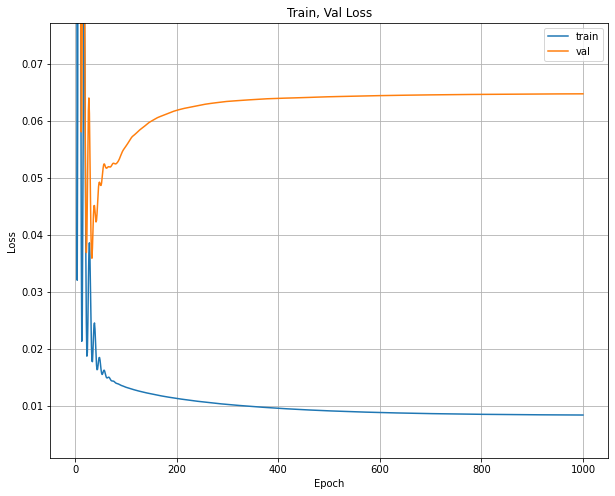

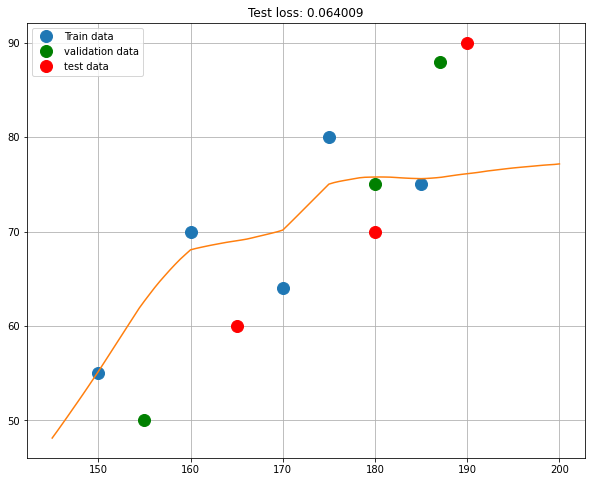

In [13]:
regularization = "No"
model_type = f"L{NoL}C{NoC}_{regularization}"
save_final_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/Regularization/final_{model_type}.pt"
loaded=torch.load(save_final_model_path, map_location=DEVICE)
load_model = loaded["model"]
EPOCH = loaded["EPOCH"]
loss_history = loaded["loss_history"]

plt.figure(figsize=[10,8])
plt.plot(range(1,EPOCH+1),loss_history["train"],label="train")
plt.plot(range(1,EPOCH+1),loss_history["val"],label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()
plt.ylim([min(loss_history["train"])*0.1, sum(loss_history["val"])/len(loss_history["val"])*1.2])

plt.figure(figsize=[10,8])
Test(load_model, test_DL, criterion)

100%|██████████| 1/1 [00:00<00:00, 256.60it/s]


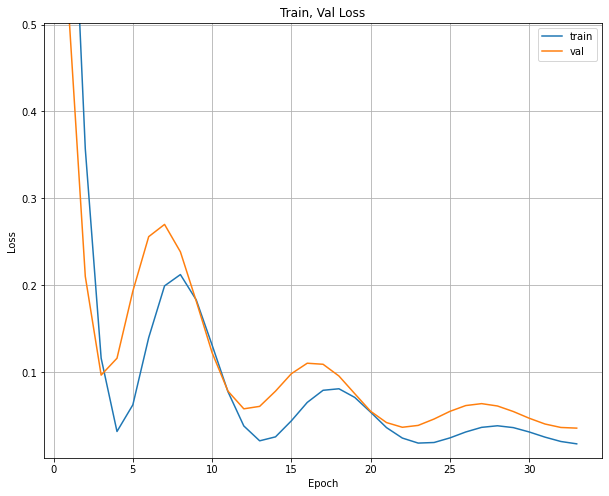

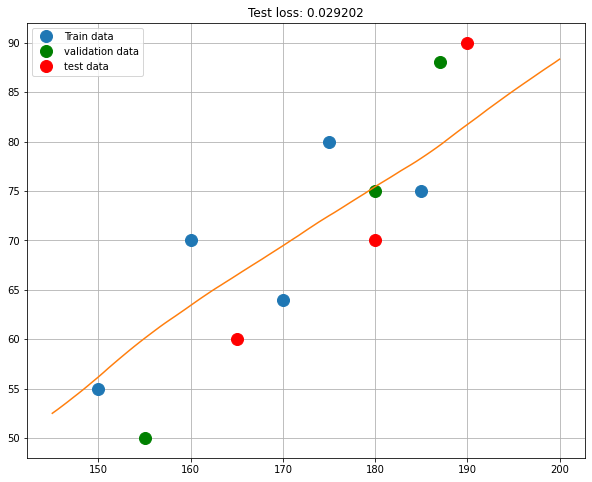

In [14]:
regularization = "No"
model_type = f"L{NoL}C{NoC}_{regularization}"
save_best_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/Regularization/best_{model_type}.pt"
loaded=torch.load(save_best_model_path, map_location=DEVICE)

load_model = loaded["model"]
EPOCH = loaded["EPOCH"]
ep = loaded["ep"]
loss_history=loaded["loss_history"]

plt.figure(figsize=[10,8])
plt.plot(range(1,ep+2),loss_history["train"],label="train")
plt.plot(range(1,ep+2),loss_history["val"],label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()
plt.ylim([min(loss_history["train"])*0.1, max(loss_history["val"])])

plt.figure(figsize=[10,8])
Test(load_model, test_DL, criterion)

100%|██████████| 1/1 [00:00<00:00, 140.27it/s]


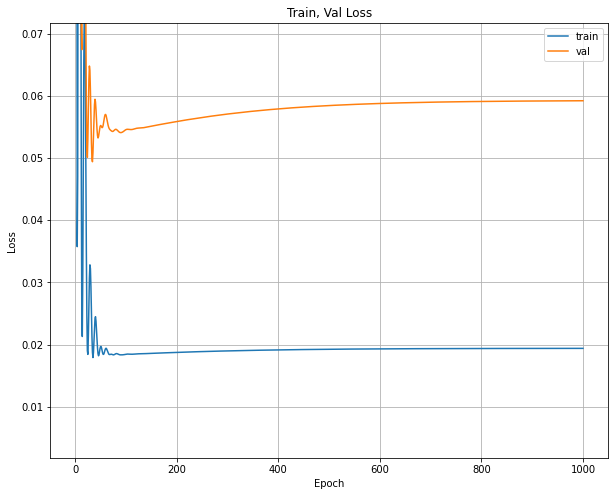

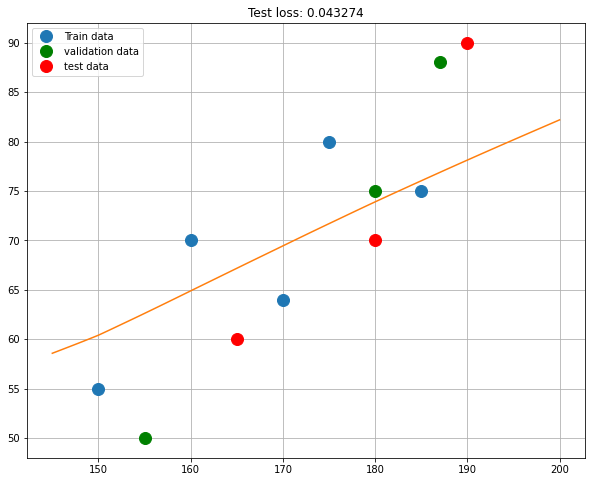

In [15]:
regularization = "l2"
if regularization == "l2":
    LAMBDA = 100
elif regularization == "l1":
    LAMBDA = 5e-3
model_type = f"L{NoL}C{NoC}_{regularization}"
save_final_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/Regularization/final_{model_type}.pt"
loaded=torch.load(save_final_model_path, map_location=DEVICE)
load_model = loaded["model"]
EPOCH = loaded["EPOCH"]
loss_history=loaded["loss_history"]

plt.figure(figsize=[10,8])
plt.plot(range(1,EPOCH+1),loss_history["train"],label="train")
plt.plot(range(1,EPOCH+1),loss_history["val"],label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()
plt.ylim([min(loss_history["train"])*0.1, sum(loss_history["val"])/len(loss_history["val"])*1.2])

plt.figure(figsize=[10,8])
Test(load_model, test_DL, criterion)

100%|██████████| 1/1 [00:00<00:00, 87.80it/s]


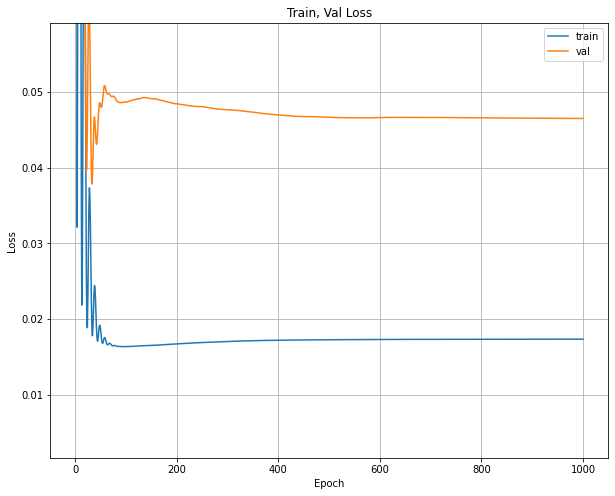

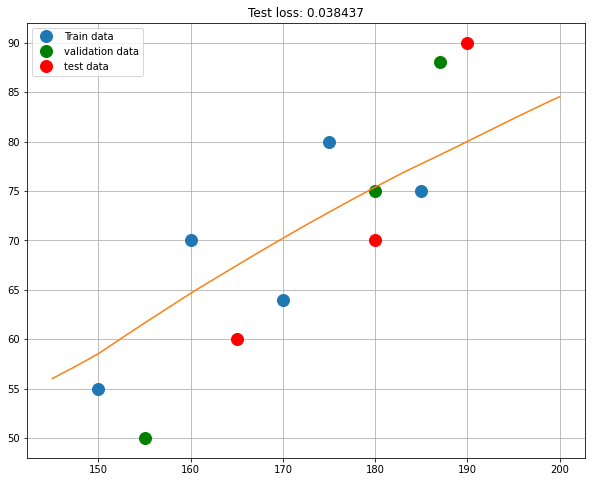

In [16]:
regularization = "l1"
if regularization == "l2":
    LAMBDA = 100
elif regularization == "l1":
    LAMBDA = 5e-3
model_type = f"L{NoL}C{NoC}_{regularization}"
save_final_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/Regularization/final_{model_type}.pt"
loaded=torch.load(save_final_model_path, map_location=DEVICE)
load_model = loaded["model"]
EPOCH = loaded["EPOCH"]
loss_history=loaded["loss_history"]

plt.figure(figsize=[10,8])
plt.plot(range(1,EPOCH+1),loss_history["train"],label="train")
plt.plot(range(1,EPOCH+1),loss_history["val"],label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()
plt.ylim([min(loss_history["train"])*0.1, sum(loss_history["val"])/len(loss_history["val"])*1.2])

plt.figure(figsize=[10,8])
Test(load_model, test_DL, criterion)

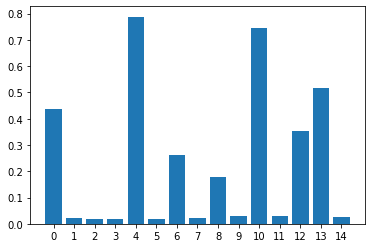

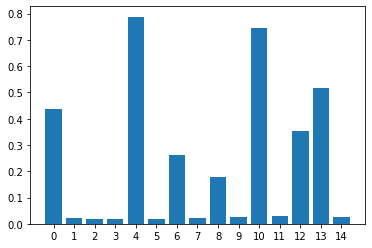

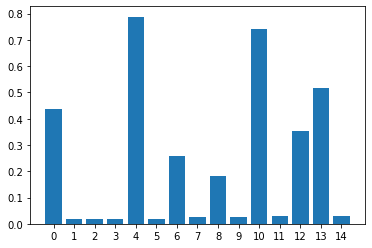

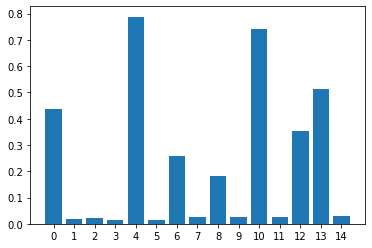

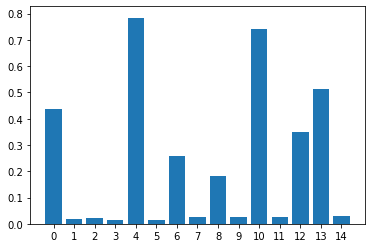

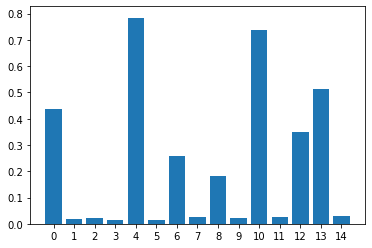

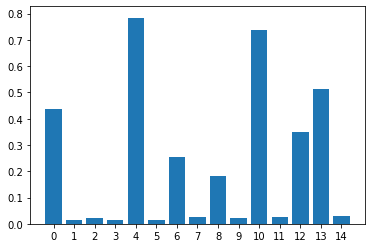

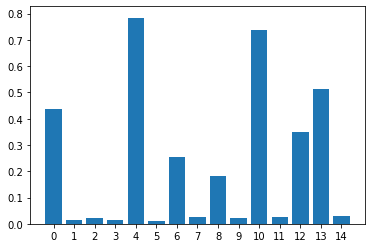

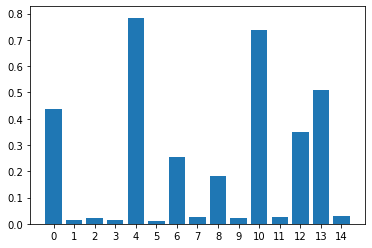

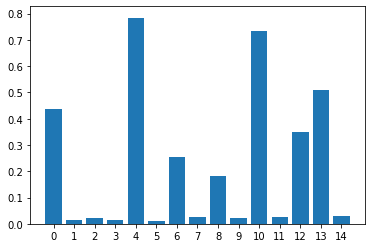

In [17]:
mean_weight_history=loaded["mean_weight_history"]
NoW = count_params(load_model)
N=15
rand_idx=torch.randint(0,NoW,(N,))

for i in range(0,10):
    plt.figure()
    plt.bar(range(N),[mean_weight_history[i][j].cpu() for j in rand_idx])
    plt.xticks(range(N), range(N))
    plt.ylim([0,max([mean_weight_history[0][j].cpu() for j in rand_idx])*1.05])

# plt.hist(mean_weight_history[i], bins=10)

In [18]:
# regularization = "No"
# model_type = f"L{NoL}C{NoC}_{regularization}"
# save_final_model_path = f"results/final_{model_type}.pt"
# loaded=torch.load(save_final_model_path, map_location=DEVICE)
# load_model = loaded["model"]
# loss_history_No=loaded["loss_history"]
# mean_weight_history_No=loaded["mean_weight_history"]
# y_plot_history_No=loaded["y_plot_history"]

# regularization = "l2"
# model_type = f"L{NoL}C{NoC}_{regularization}"
# save_final_model_path = f"results/final_{model_type}.pt"
# loaded=torch.load(save_final_model_path, map_location=DEVICE)
# loss_history_l2=loaded["loss_history"]
# mean_weight_history_l2=loaded["mean_weight_history"]
# y_plot_history_l2=loaded["y_plot_history"]

# regularization = "l1"
# model_type = f"L{NoL}C{NoC}_{regularization}"
# save_final_model_path = f"results/final_{model_type}.pt"
# loaded=torch.load(save_final_model_path, map_location=DEVICE)
# loss_history_l1=loaded["loss_history"]
# mean_weight_history_l1=loaded["mean_weight_history"]
# y_plot_history_l1=loaded["y_plot_history"]

# from matplotlib.animation import FuncAnimation
# fig = plt.figure(figsize=[18, 10])
# NoW = sum([p.numel() for p in load_model.parameters() if p.requires_grad])
# N=15
# rand_idx=torch.randint(0,NoW,(N,))

# max_No=max([max([mean_weight_history_No[i][j].cpu() for j in rand_idx]) for i in range(EPOCH)])
# max_l2=max([max([mean_weight_history_l2[i][j].cpu() for j in rand_idx]) for i in range(EPOCH)])
# max_l1=max([max([mean_weight_history_l1[i][j].cpu() for j in rand_idx]) for i in range(EPOCH)])

# x_plot = torch.linspace(145,200,100).reshape(-1,1)

# def animate(i): # for 문의 i 라고 생각하면 됨
#     plt.clf()
    
#     plt.suptitle(f"Epoch: {range(1,EPOCH+1)[i]}")
    
#     plt.subplot(3,3,1)
#     plt.bar(range(N),[mean_weight_history_No[i][j].cpu() for j in rand_idx])
#     plt.grid(alpha=0.5)
#     plt.xticks(range(N), range(N))
#     plt.ylim([0,max_No*1.05])
#     plt.xlabel("weight number")
#     plt.ylabel("mean absolute value")
#     plt.title("No regularization")
    
#     plt.subplot(3,3,2)
#     plt.bar(range(N),[mean_weight_history_l2[i][j].cpu() for j in rand_idx])
#     plt.grid(alpha=0.5)
#     plt.xticks(range(N), range(N))
#     plt.ylim([0,max_l2*1.05])
#     plt.xlabel("weight number")
#     plt.ylabel("mean absolute value")
#     plt.title("l2-regularization")
    
#     plt.subplot(3,3,3)
#     plt.bar(range(N),[mean_weight_history_l1[i][j].cpu() for j in rand_idx])
#     plt.grid(alpha=0.5)
#     plt.xticks(range(N), range(N))
#     plt.ylim([0,max_l1*1.05])
#     plt.xlabel("weight number")
#     plt.ylabel("mean absolute value")
#     plt.title("l1-regularization")
    
#     plt.subplot(3,3,4)
#     plt.plot(range(1,EPOCH+1)[:i+1],loss_history_No["train"][:i+1],label="train")
#     plt.plot(range(1,EPOCH+1)[:i+1],loss_history_No["val"][:i+1],label="val")
#     plt.xlim([-5, EPOCH+5])
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.grid()
#     plt.legend()
#     plt.ylim([0,0.15])
    
#     plt.subplot(3,3,5)
#     plt.plot(range(1,EPOCH+1)[:i+1],loss_history_l2["train"][:i+1],label="train")
#     plt.plot(range(1,EPOCH+1)[:i+1],loss_history_l2["val"][:i+1],label="val")
#     plt.xlim([-5, EPOCH+5])
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.grid()
#     plt.legend()
#     plt.ylim([0,0.15])
    
#     plt.subplot(3,3,6)
#     plt.plot(range(1,EPOCH+1)[:i+1],loss_history_l1["train"][:i+1],label="train")
#     plt.plot(range(1,EPOCH+1)[:i+1],loss_history_l1["val"][:i+1],label="val")
#     plt.xlim([-5, EPOCH+5])
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.grid()
#     plt.legend()
#     plt.ylim([0,0.15])
    
#     plt.subplot(3,3,7)
#     plt.plot(x,y,'o', markersize=9, label="Train data")
#     plt.plot(xv,yv,'go', markersize=9, label="validation data")
#     plt.plot(xt,yt,'ro', markersize=9, label="test data")
#     plt.plot(x_plot, y_plot_history_No[i].cpu(),linewidth=1.5)
#     plt.grid()
#     plt.xlim([145, 200])
#     plt.ylim([48, 92])
#     plt.legend(loc="upper left")
    
#     plt.subplot(3,3,8)
#     plt.plot(x,y,'o', markersize=9, label="Train data")
#     plt.plot(xv,yv,'go', markersize=9, label="validation data")
#     plt.plot(xt,yt,'ro', markersize=9, label="test data")
#     plt.plot(x_plot, y_plot_history_l2[i].cpu(),linewidth=1.5)
#     plt.grid()
#     plt.xlim([145, 200])
#     plt.ylim([48, 92])
#     plt.legend(loc="upper left")
    
#     plt.subplot(3,3,9)
#     plt.plot(x,y,'o', markersize=9, label="Train data")
#     plt.plot(xv,yv,'go', markersize=9, label="validation data")
#     plt.plot(xt,yt,'ro', markersize=9, label="test data")
#     plt.plot(x_plot, y_plot_history_l1[i].cpu(),linewidth=1.5)
#     plt.grid()
#     plt.xlim([145, 200])
#     plt.ylim([48, 92])
#     plt.legend(loc="upper left")
#     # plt.tight_layout()
    
# ani = FuncAnimation(fig, animate, frames=range(0,1000,5), interval=50) 
# # frames 에 10 넣으면 for i in range(10) 이라고 보면 됨. 혹은 list 넣어주면 in list
# ani.save(save_video_path, writer='imagemagick')